<a href="https://colab.research.google.com/github/Thiru2208/CM2607_CW/blob/main/2425449_20241152_CM2607_CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [636]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from numpy.fft import rfft, rfftfreq
import cv2

# 1. Modelling Travel Time

In [637]:
# =========================
# 1. Modelling Travel Time
# =========================

In [638]:
# ----- Define symbols (symbolic variables) -----
x, y = sp.symbols('x y', positive=True, real=True)        # x = distance (km), y = traffic delay factor (min/km)
a, b, c = sp.symbols('a b c', positive=True, real=True)   # a, b, c = model parameters/constants

# ----- Define travel time models (given in question) -----
Tb = a*x**2 + b*y**2                      # Bus travel time model Tb(x,y)
Tt = sp.sqrt(c*(x**2 + y**2))             # Taxi travel time model Tt(x,y)

Tb, Tt

(a*x**2 + b*y**2, sqrt(c)*sqrt(x**2 + y**2))

In [639]:
# ----- Part (a): Compute gradients (partial derivatives) -----
dTb_dx = sp.diff(Tb, x)
dTb_dy = sp.diff(Tb, y)
dTt_dx = sp.diff(Tt, x)
dTt_dy = sp.diff(Tt, y)

grad_Tb = (sp.simplify(dTb_dx), sp.simplify(dTb_dy))   # Gradient vector of Tb
grad_Tt = (sp.simplify(dTt_dx), sp.simplify(dTt_dy))   # Gradient vector of Tt

print("Gradient for bus is ", grad_Tb)
print("Gradient for Taxi is ", grad_Tt)

Gradient for bus is  (2*a*x, 2*b*y)
Gradient for Taxi is  (sqrt(c)*x/sqrt(x**2 + y**2), sqrt(c)*y/sqrt(x**2 + y**2))


In [640]:
# ----- Part (b): Numerical evaluation to interpret which factor matters more -----
# NOTE: a0, b0, c0 are assumed parameter values for illustration (since real values not given)

In [641]:
# ----- Numeric evaluation helper -----
x0 = 4.5        # Fixed route distance (km) for evaluation

a0 = 2.0        # Example value for parameter a (distance effect on bus)
b0 = 1.0        # Example value for parameter b (traffic effect on bus)
c0 = 9.0        # Example value for parameter c (overall scaling for taxi)

# Choose a few traffic delay values (min/km) to see sensitivity change with congestion
y_values = [1, 3, 6]

# Substitute numeric values into the partial derivatives and print results
for y0 in y_values:
    # Evaluate partial derivatives at (x0, y0)
    bus_dx = float(dTb_dx.subs({a:a0, x:x0}))
    bus_dy = float(dTb_dy.subs({b:b0, y:y0}))

    taxi_dx = float(dTt_dx.subs({c:c0, x:x0, y:y0}))
    taxi_dy = float(dTt_dy.subs({c:c0, x:x0, y:y0}))

    print(f"\nAt x={x0} km, y={y0} min/km")
    print(f"Bus:  ∂Tb/∂x = {bus_dx:.3f},  ∂Tb/∂y = {bus_dy:.3f}")    # Bus sensitivities
    print(f"Taxi: ∂Tt/∂x = {taxi_dx:.3f},  ∂Tt/∂y = {taxi_dy:.3f}")  # Taxi sensitivities


At x=4.5 km, y=1 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 2.000
Taxi: ∂Tt/∂x = 2.929,  ∂Tt/∂y = 0.651

At x=4.5 km, y=3 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 6.000
Taxi: ∂Tt/∂x = 2.496,  ∂Tt/∂y = 1.664

At x=4.5 km, y=6 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 12.000
Taxi: ∂Tt/∂x = 1.800,  ∂Tt/∂y = 2.400


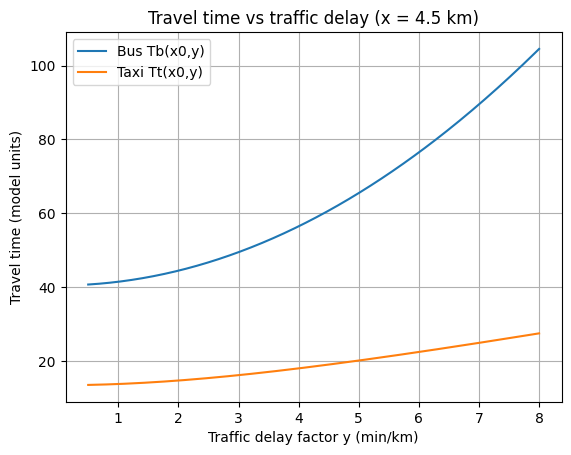

In [642]:
# ----- Plot travel time vs traffic delay (keeping distance fixed at x0) -----
ys = np.linspace(0.5, 8.0, 250)            # Range of traffic delay values for smooth curve

Tb_num = a0*(x0**2) + b0*(ys**2)           # Numeric bus travel time for each y in ys
Tt_num = np.sqrt(c0*((x0**2) + (ys**2)))   # Numeric taxi travel time for each y in ys

plt.figure()                               # Create a new figure
plt.plot(ys, Tb_num, label="Bus Tb(x0,y)") # Plot bus curve
plt.plot(ys, Tt_num, label="Taxi Tt(x0,y)")# Plot taxi curve
plt.xlabel("Traffic delay factor y (min/km)")  # X-axis label
plt.ylabel("Travel time (model units)")        # Y-axis label
plt.title("Travel time vs traffic delay (x = 4.5 km)")  # Graph title
plt.grid(True)                             # Show grid
plt.legend()                               # Show legend
plt.show()                                 # Display plot


In [674]:
# ----- Interpretation text (Part b explanation) -----
print(
    "1. For the bus model, sensitivity to distance is 2ax (so it increases with distance), \n"
    "and sensitivity to traffic is 2by (so it increases with traffic delay)./n"
)
print(
  "2. This means that when traffic delay y is small, the distance effect (2*a*x) can dominate, \n"
  "but as congestion increases, the term 2*b*y grows and can become the stronger factor.\n"
  "For smaller y, distance dominates; for larger y, traffic congestion dominates the travel time.")
print(
    "3. For the taxi model Tt = sqrt(c*(x^2 + y^2)), the gradient distributes the influence of distance and delay \n"
    "through the common denominator sqrt(x^2 + y^2)."
)
print(
    "4. When traffic delay is small, both distance and delay contribute similarly, but as y grows larger, \n"
    "the sensitivity dTt/dy overtakes dTt/dx."
)
print("5. Since both variables are inside the same root term, their influence is \n"
      "balanced at first but tilts toward y under heavy traffic.")
print(
    "6. Therefore, taxi travel time becomes increasingly influenced by heavy traffic, showing that congestion affects both \n"
    "modes but impacts the bus more sharply at high delay levels."
)

1. For the bus model, sensitivity to distance is 2ax (so it increases with distance), 
and sensitivity to traffic is 2by (so it increases with traffic delay)./n
2. This means that when traffic delay y is small, the distance effect (2*a*x) can dominate, 
but as congestion increases, the term 2*b*y grows and can become the stronger factor.
For smaller y, distance dominates; for larger y, traffic congestion dominates the travel time.
3. For the taxi model Tt = sqrt(c*(x^2 + y^2)), the gradient distributes the influence of distance and delay 
through the common denominator sqrt(x^2 + y^2).
4. When traffic delay is small, both distance and delay contribute similarly, but as y grows larger, 
the sensitivity dTt/dy overtakes dTt/dx.
5. Since both variables are inside the same root term, their influence is 
balanced at first but tilts toward y under heavy traffic.
6. Therefore, taxi travel time becomes increasingly influenced by heavy traffic, showing that congestion affects both 
modes but im

# 2. Cost Analysis Using Integration

In [644]:
#Symbolic Integration

# Define symbols
t = sp.symbols('t', real=True)
x_sym = sp.symbols('x', nonnegative=True, real=True)

# Cost-rate functions
rate_bus = 2*t + 1
rate_taxi = 3*t + 2

# Integrate from 0 to x
Fb_expr = sp.integrate(rate_bus, (t, 0, x_sym))
Ft_expr = sp.integrate(rate_taxi, (t, 0, x_sym))

print("Fb(x) =", Fb_expr)
print("Ft(x) =", Ft_expr)

Fb(x) = x**2 + x
Ft(x) = 3*x**2/2 + 2*x


In [645]:
# Convert symbolic expressions into numeric functions
Fb = sp.lambdify(x_sym, Fb_expr, 'numpy')
Ft = sp.lambdify(x_sym, Ft_expr, 'numpy')


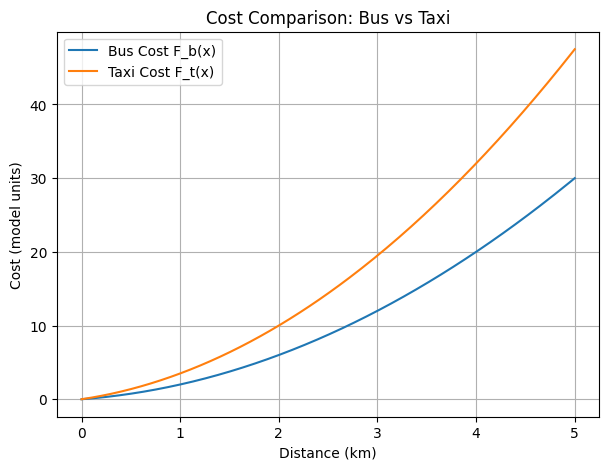

In [646]:
# Distance values 0–5 km
xs = np.linspace(0, 5, 200)

plt.figure(figsize=(7,5))
plt.plot(xs, Fb(xs), label="Bus Cost F_b(x)")
plt.plot(xs, Ft(xs), label="Taxi Cost F_t(x)")
plt.xlabel("Distance (km)")
plt.ylabel("Cost (model units)")
plt.title("Cost Comparison: Bus vs Taxi")
plt.grid(True)
plt.legend()
plt.show()

In [647]:
print("""When we look at the integrated cost functions for the bus and taxi, the bus cost
Fb(x) = x + x^2
grows more slowly because both the linear and quadratic parts are smaller. The taxi cost
Ft(x) = 2x + 3/2 x^2
increases faster, since it starts with a higher basic rate and its squared term also has
a bigger coefficient. For short distances, the difference between the two costs isn’t very
large, but as the distance increases, the taxi price rises much more quickly than the bus price.
This shows that the bus remains the cheaper option overall, especially for longer trips, because
the cost growth is slower compared to the taxi.
""")

When we look at the integrated cost functions for the bus and taxi, the bus cost
Fb(x) = x + x^2
grows more slowly because both the linear and quadratic parts are smaller. The taxi cost
Ft(x) = 2x + 3/2 x^2
increases faster, since it starts with a higher basic rate and its squared term also has
a bigger coefficient. For short distances, the difference between the two costs isn’t very
large, but as the distance increases, the taxi price rises much more quickly than the bus price.
This shows that the bus remains the cheaper option overall, especially for longer trips, because
the cost growth is slower compared to the taxi.



# 3. Predicting Peak Travel Times Using Series Convergence

In [648]:
# Series approximation of P(t) using FIRST 4 NON-ZERO TERMS

t = sp.symbols("t", real=True)

P = 5 + 4*sp.sin(sp.pi*t) - sp.Rational(3,2)*t**2 + sp.Rational(1,4)*t**4

In [649]:
P_4_s = sp.simplify(P)
P_4_s

t**4/4 - 3*t**2/2 + 4*sin(pi*t) + 5

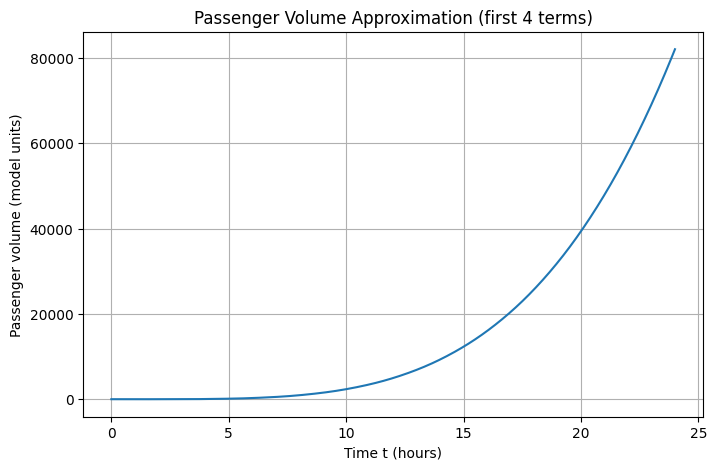

t=24.00 h, P=82085.000
t=23.95 h, P=81424.972
t=23.90 h, P=80768.931
t=23.86 h, P=80116.876
t=23.81 h, P=79468.804


In [650]:
P_func = sp.lambdify(t, P_4_s, 'numpy')

ts = np.linspace(0, 24, 500)
vals = P_func(ts)

plt.figure(figsize=(8,5))
plt.plot(ts, vals)
plt.xlabel("Time t (hours)")
plt.ylabel("Passenger volume (model units)")
plt.title("Passenger Volume Approximation (first 4 terms)")
plt.grid(True)
plt.show()

#Peack travel periods
k = 5
top_idx = np.argsort(vals)[-k:][::-1]
for i in top_idx:
    print(f"t={ts[i]:.2f} h, P={vals[i]:.3f}")


# 4. Travel Pattern Analysis Using Fourier Transform

In [651]:
# Since real boarding-count data was not provided, I simulated realistic boarding patterns (morning + evening rush) to demonstrate Fourier analysis.

In [652]:
# Time settings: 6 AM to 9 PM, every 5 minutes
dt = 5  # minutes
time_hours = np.arange(6, 21, dt/60)

# Simulated boarding counts (morning + evening peaks)
bus_counts = (
    40
    + 35*np.exp(-0.5*((time_hours-8)/0.8)**2)
    + 45*np.exp(-0.5*((time_hours-17.5)/1.0)**2)
)

taxi_counts = (
    30
    + 25*np.exp(-0.5*((time_hours-8.5)/0.9)**2)
    + 30*np.exp(-0.5*((time_hours-18)/1.1)**2)
)

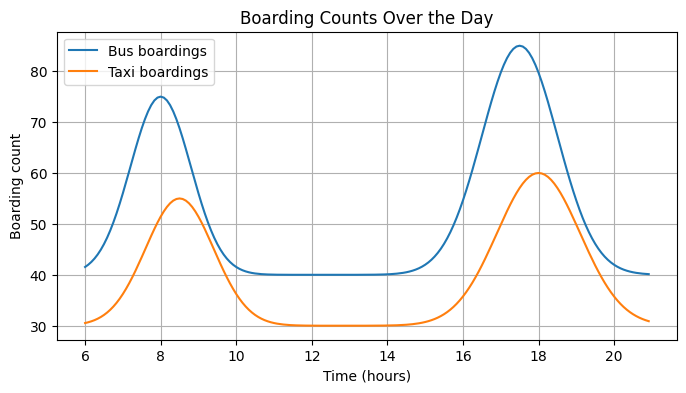

In [653]:
# Plot original signals
plt.figure(figsize=(8,4))
plt.plot(time_hours, bus_counts, label="Bus boardings")
plt.plot(time_hours, taxi_counts, label="Taxi boardings")
plt.xlabel("Time (hours)")
plt.ylabel("Boarding count")
plt.title("Boarding Counts Over the Day")
plt.grid(True)
plt.legend()
plt.show()

In [654]:
# Remove mean (important for FFT)
bus_detrended = bus_counts - np.mean(bus_counts)
taxi_detrended = taxi_counts - np.mean(taxi_counts)

# Fourier Transform
bus_fft = np.abs(rfft(bus_detrended))
taxi_fft = np.abs(rfft(taxi_detrended))

# Frequency axis (cycles per hour)
freqs = rfftfreq(len(bus_counts), d=dt/60)

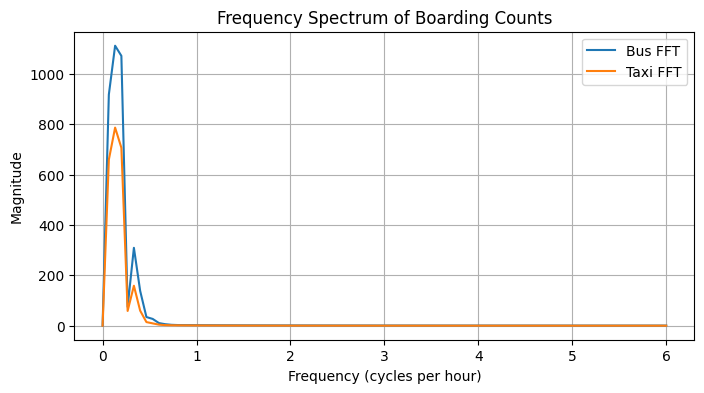

In [655]:
plt.figure(figsize=(8,4))
plt.plot(freqs, bus_fft, label="Bus FFT")
plt.plot(freqs, taxi_fft, label="Taxi FFT")
plt.xlabel("Frequency (cycles per hour)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum of Boarding Counts")
plt.grid(True)
plt.legend()
plt.show()


In [656]:
# Ignore zero-frequency (mean)
bus_fft_no0 = bus_fft.copy()
bus_fft_no0[0] = 0

taxi_fft_no0 = taxi_fft.copy()
taxi_fft_no0[0] = 0

bus_peak_freq = freqs[np.argmax(bus_fft_no0)]
taxi_peak_freq = freqs[np.argmax(taxi_fft_no0)]

bus_peak_freq, taxi_peak_freq

(np.float64(0.13333333333333333), np.float64(0.13333333333333333))

In [657]:
print("The boarding count plots show two clear peak periods during the day, one in the morning and another in the evening, which correspond to typical commuting hours.")
print("After applying the Fourier Transform, the dominant frequency for both bus and taxi boarding data is approximately 0.133 cycles per hour.")
print("This dominant frequency corresponds to a repeating pattern with a period of about 7.5 hours, indicating regular daily travel demand cycles.")
print("The presence of the same dominant frequency for buses and taxis suggests that both transport modes follow similar daily usage patterns.")
print("However, the magnitude of the bus Fourier components is higher, showing that buses carry a larger number of passengers compared to taxis.")
print("Overall, the Fourier analysis successfully identifies peak travel periods and demonstrates how frequency-domain methods can support transport planning and scheduling.")

The boarding count plots show two clear peak periods during the day, one in the morning and another in the evening, which correspond to typical commuting hours.
After applying the Fourier Transform, the dominant frequency for both bus and taxi boarding data is approximately 0.133 cycles per hour.
This dominant frequency corresponds to a repeating pattern with a period of about 7.5 hours, indicating regular daily travel demand cycles.
The presence of the same dominant frequency for buses and taxis suggests that both transport modes follow similar daily usage patterns.
However, the magnitude of the bus Fourier components is higher, showing that buses carry a larger number of passengers compared to taxis.
Overall, the Fourier analysis successfully identifies peak travel periods and demonstrates how frequency-domain methods can support transport planning and scheduling.


# 5. Image Processing Using Fourier and Discrete Cosine Transforms


In [658]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


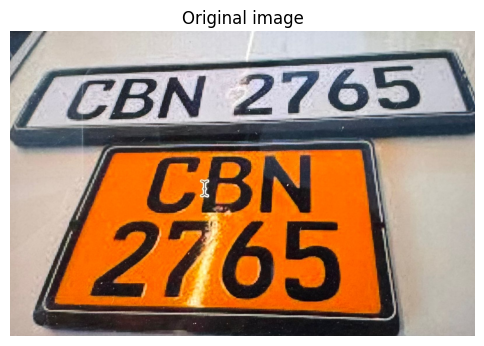

In [659]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/drive/MyDrive/MathsCw/vehicle_plate.png"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError("vehicle_plate.png not found.")

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original image")
plt.axis("off")
plt.show()

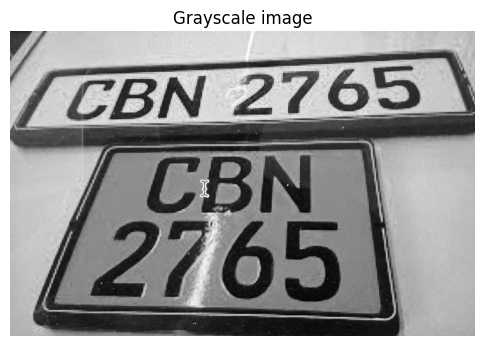

In [660]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6,4))
plt.imshow(gray, cmap="gray")
plt.title("Grayscale image")
plt.axis("off")
plt.show()

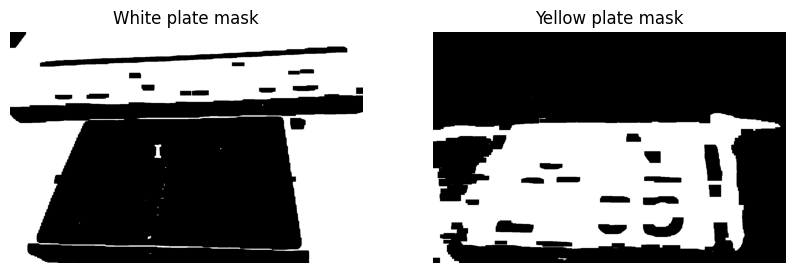

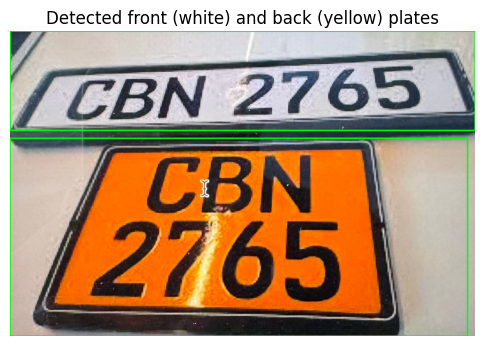

In [661]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Front plate (white): low saturation + high brightness
white_mask = cv2.inRange(hsv, (0, 0, 160), (180, 70, 255))

# Back plate (yellow): hue range for yellow (tune if needed)
yellow_mask = cv2.inRange(hsv, (10, 40, 60), (55, 255, 255))

# Clean masks
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 9))
white_clean  = cv2.morphologyEx(white_mask,  cv2.MORPH_CLOSE, kernel, iterations=2)
yellow_clean = cv2.morphologyEx(yellow_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

# Show masks (important for debugging)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(white_clean, cmap="gray");  plt.title("White plate mask");  plt.axis("off")
plt.subplot(1,2,2); plt.imshow(yellow_clean, cmap="gray"); plt.title("Yellow plate mask"); plt.axis("off")
plt.show()

def largest_box(mask):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    return x, y, w, h

front_box = largest_box(white_clean)   # white = front
back_box  = largest_box(yellow_clean)  # yellow = back

if front_box is None or back_box is None:
    raise ValueError("Plate detection failed. Adjust HSV ranges (yellow/white) based on mask images.")

x1, y1, w1, h1 = front_box
x2, y2, w2, h2 = back_box

# Draw boxes to verify
vis = img.copy()
cv2.rectangle(vis, (x1,y1), (x1+w1, y1+h1), (0,255,0), 3)
cv2.rectangle(vis, (x2,y2), (x2+w2, y2+h2), (0,255,0), 3)

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Detected front (white) and back (yellow) plates")
plt.axis("off")
plt.show()

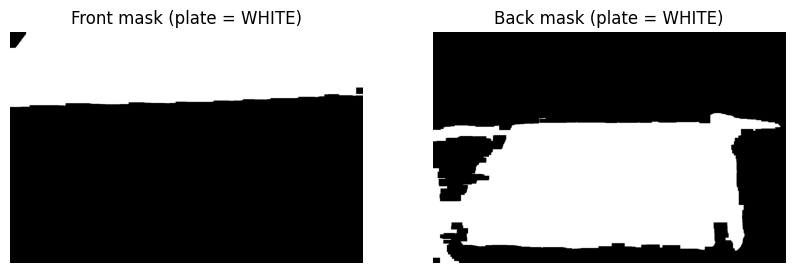

In [662]:
def make_plate_white(mask):
    mask = (mask > 0).astype(np.uint8) * 255

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros_like(mask)

    if cnts:
        c = max(cnts, key=cv2.contourArea)
        cv2.drawContours(filled, [c], -1, 255, thickness=-1)  # fill plate region white

    return filled

white_clean  = make_plate_white(white_clean)   # front (white plate) mask
yellow_clean = make_plate_white(yellow_clean)  # back (yellow plate) mask

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(white_clean, cmap="gray");  plt.title("Front mask (plate = WHITE)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(yellow_clean, cmap="gray"); plt.title("Back mask (plate = WHITE)");  plt.axis("off")
plt.show()


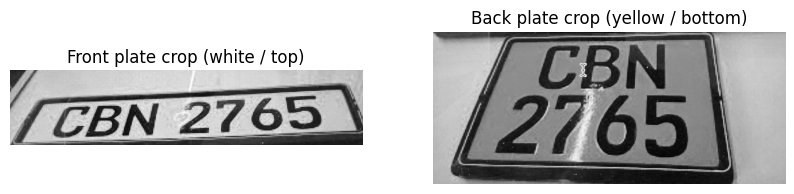

In [663]:
front_plate = gray[y1:y1+h1, x1:x1+w1]  # top rectangle
back_plate  = gray[y2:y2+h2, x2:x2+w2]  # bottom rectangle

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(front_plate, cmap="gray")
plt.title("Front plate crop (white / top)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(back_plate, cmap="gray")
plt.title("Back plate crop (yellow / bottom)")
plt.axis("off")
plt.show()


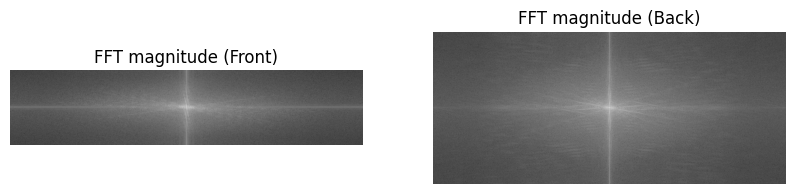

In [664]:
def fft_magnitude(img_gray):
    F = np.fft.fft2(img_gray)
    F_shifted = np.fft.fftshift(F)
    mag = 20 * np.log(np.abs(F_shifted) + 1)
    return mag

front_fft = fft_magnitude(front_plate)
back_fft  = fft_magnitude(back_plate)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(front_fft, cmap="gray")
plt.title("FFT magnitude (Front)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(back_fft, cmap="gray")
plt.title("FFT magnitude (Back)")
plt.axis("off")
plt.show()


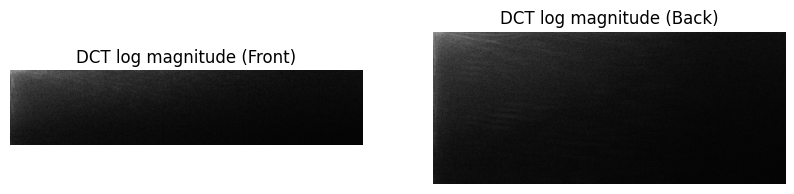

In [665]:
def dct_log_magnitude(img_gray):
    img_float = np.float32(img_gray)
    D = cv2.dct(img_float)
    return np.log(np.abs(D) + 1)

front_dct = dct_log_magnitude(front_plate)
back_dct  = dct_log_magnitude(back_plate)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(front_dct, cmap="gray")
plt.title("DCT log magnitude (Front)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(back_dct, cmap="gray")
plt.title("DCT log magnitude (Back)")
plt.axis("off")
plt.show()


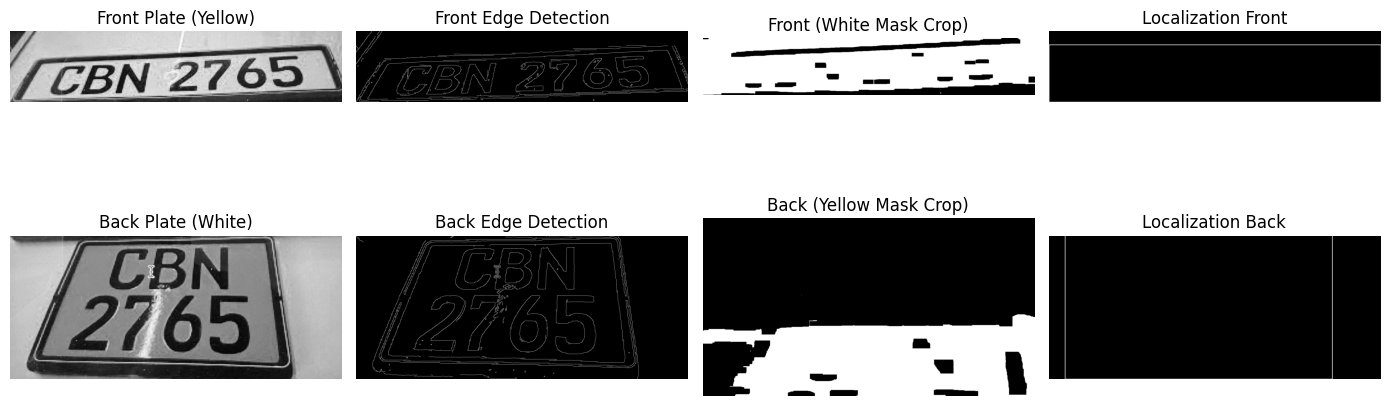

In [666]:
def localise_plate_black(plate_gray):
    # 1️⃣ Blur
    blur = cv2.GaussianBlur(plate_gray, (5, 5), 0)

    # 2️⃣ Edge detection
    edges = cv2.Canny(blur, 50, 150)

    # 3️⃣ Connect edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    thick  = cv2.dilate(closed, kernel, iterations=1)

    # 4️⃣ Contours
    cnts, _ = cv2.findContours(thick, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    H, W = plate_gray.shape
    best_cnt = None
    for c in sorted(cnts, key=cv2.contourArea, reverse=True):
        x, y, w, h = cv2.boundingRect(c)
        area = w * h
        aspect = w / float(h)
        if area > 0.08 * H * W and 1.5 < aspect < 10.0:
            best_cnt = c
            break
    if best_cnt is None and cnts:
        best_cnt = max(cnts, key=cv2.contourArea)

    # 5️⃣ Binary fill
    binary_fill = np.zeros((H, W), dtype=np.uint8)
    if best_cnt is not None:
        cv2.drawContours(binary_fill, [best_cnt], -1, 255, -1)
    binary_fill = cv2.morphologyEx(binary_fill, cv2.MORPH_CLOSE, np.ones((9, 9), np.uint8))

    # 6️⃣ Localization rectangle
    loc = np.zeros((H, W, 3), dtype=np.uint8)
    if best_cnt is not None:
        x, y, w, h = cv2.boundingRect(best_cnt)
        cv2.rectangle(loc, (x, y), (x + w, y + h), (255, 255, 255), 2)

    # 7️⃣ Crop
    if best_cnt is not None:
        x, y, w, h = cv2.boundingRect(best_cnt)
        binary_crop = binary_fill[y:y+h, x:x+w]
    else:
        binary_crop = binary_fill.copy()

    return edges, binary_fill, loc, (x, y, w, h) if best_cnt is not None else None, binary_crop


# ---------- RUN EDGE & CONTOUR LOGIC ----------
front_edges, front_bin, front_loc, front_bbox, front_bin_crop = localise_plate_black(front_plate)
back_edges,  back_bin,  back_loc,  back_bbox,  back_bin_crop  = localise_plate_black(back_plate)

# ---------- HSV MASKING ----------
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
white_mask = cv2.inRange(hsv, (0, 0, 160), (180, 70, 255))
yellow_mask = cv2.inRange(hsv, (10, 40, 60), (55, 255, 255))

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 9))
white_clean  = cv2.morphologyEx(white_mask,  cv2.MORPH_CLOSE, kernel, iterations=2)
yellow_clean = cv2.morphologyEx(yellow_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

# ---------- CROP MASKS TO PLATE BBOX ----------
if front_bbox is not None:
    x, y, w, h = front_bbox
    white_crop = white_clean[y:y+h, x:x+w]
else:
    white_crop = white_clean

if back_bbox is not None:
    x, y, w, h = back_bbox
    yellow_crop = yellow_clean[y:y+h, x:x+w]
else:
    yellow_crop = yellow_clean

# ---------- DISPLAY ALL ----------
plt.figure(figsize=(14,6))
# FRONT (Yellow plate)
plt.subplot(2,4,1); plt.imshow(front_plate, cmap="gray"); plt.title("Front Plate (Yellow)"); plt.axis("off")
plt.subplot(2,4,2); plt.imshow(front_edges, cmap="gray"); plt.title("Front Edge Detection"); plt.axis("off")
plt.subplot(2,4,3); plt.imshow(white_crop, cmap="gray"); plt.title("Front (White Mask Crop)"); plt.axis("off")
plt.subplot(2,4,4); plt.imshow(front_loc); plt.title("Localization Front"); plt.axis("off")

# BACK (White plate)
plt.subplot(2,4,5); plt.imshow(back_plate, cmap="gray"); plt.title("Back Plate (White)"); plt.axis("off")
plt.subplot(2,4,6); plt.imshow(back_edges, cmap="gray"); plt.title("Back Edge Detection"); plt.axis("off")
plt.subplot(2,4,7); plt.imshow(yellow_crop, cmap="gray"); plt.title("Back (Yellow Mask Crop)"); plt.axis("off")
plt.subplot(2,4,8); plt.imshow(back_loc); plt.title("Localization Back"); plt.axis("off")

plt.tight_layout()
plt.show()

In [667]:
print("The 2D Fourier Transform shows the distribution of spatial frequencies in the number plate image, where low‑frequency components represent smooth background regions and high‑frequency components represent edges and characters.")
print("High‑frequency components in the Fourier magnitude spectrum correspond to sharp transitions such as text, borders, and plate boundaries, which are crucial for number plate identification.")
print("The Discrete Cosine Transform (DCT) concentrates most of the image energy into low‑frequency coefficients, while mid‑ and high‑frequency coefficients capture character strokes and fine details.")
print("Fourier and DCT analysis help number plate recognition systems by enabling feature extraction, edge enhancement, noise reduction, and efficient preprocessing before optical character recognition (OCR).")
print("In traffic optimisation, these techniques support automated vehicle recognition, traffic flow monitoring, congestion detection, and improved route planning and transport management.")

The 2D Fourier Transform shows the distribution of spatial frequencies in the number plate image, where low‑frequency components represent smooth background regions and high‑frequency components represent edges and characters.
High‑frequency components in the Fourier magnitude spectrum correspond to sharp transitions such as text, borders, and plate boundaries, which are crucial for number plate identification.
The Discrete Cosine Transform (DCT) concentrates most of the image energy into low‑frequency coefficients, while mid‑ and high‑frequency coefficients capture character strokes and fine details.
Fourier and DCT analysis help number plate recognition systems by enabling feature extraction, edge enhancement, noise reduction, and efficient preprocessing before optical character recognition (OCR).
In traffic optimisation, these techniques support automated vehicle recognition, traffic flow monitoring, congestion detection, and improved route planning and transport management.


In [668]:
print("The Fourier Transform operates on complex frequency components and is symmetric, whereas the DCT works with only real coefficients, making it more efficient for compression and suitable for JPEG and real-time image analysis.")

The Fourier Transform operates on complex frequency components and is symmetric, whereas the DCT works with only real coefficients, making it more efficient for compression and suitable for JPEG and real-time image analysis.
